In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import OrderedDict
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

from npiv import iv_simulator, custom_objectives, model_wrapper, NonparametricIV

In [29]:
# 0. random data.  price is endogenous, instrument is this 
n = 60000 # number of observations
d = 2 # dimensionality of the exogenous regressors in x
    
ivsim = iv_simulator.IVSimulator(num_exog_x_cols=d, numpy_random_seed=0)
df = ivsim.generate_data(num_obs=n)
df['id'] = np.arange(n)

test_cutoff = 50000
df_train = df.iloc[:test_cutoff,:]
df_test = df.iloc[test_cutoff:,:]

# Helper functions

In [38]:
#  we'll be doing some experiments where we use the true quantiles to test
#  just the second stage of the NonparmatricIV process, an in order to do that
#  we'll need a class for producing true quantiles in this synthetic example
class TrueQtlModel:
    elast_max = ivsim.elast_max
    elast_min = ivsim.elast_min
    log_cost_coefs = ivsim.log_cost_coefs
    exog_x_cols = ivsim.exog_x_cols
    instrument_col = ivsim.instrument_col
    def __init__(self, alpha):
        self.alpha=alpha
    def feature_name(self):
        return self.exog_x_cols+[self.instrument_col]
    def predict(self, df):
        elast_qtl = self.alpha * (self.elast_max - self.elast_min) + self.elast_min 
        log_costs = iv_simulator.generate_log_costs(df[self.exog_x_cols], self.log_cost_coefs)
        log_price_qtl = iv_simulator.generate_log_optimal_prices(log_costs, elast_qtl) + df[self.instrument_col]
        return log_price_qtl

In [56]:

def plot_performance_and_implied_margin_effects_vs_iteration(model, df_test, num_grid_pts=50):
    '''
    function to compute and plot the distribution of marginal effects of a model,
        with respect to each of the model features, at the various points defined
        by df_tests    
    model should be some NonparametricIv.stage2_model when trained with 'lgb' option
    df_test should be some hold-out data
    '''
    metric_name = 'grouped sse'
    eval_results = model.eval_results['val'][metric_name]
    num_iters = len(eval_results)
    # generate time series of marginal effects
    dfs_to_concat = []
    for num_iteration in np.linspace(1,num_iters, num_grid_pts, dtype=int):
        print(num_iteration, end=" ")
        mfx = model.marginal_effect_plots(df_test, plot=False, predict_kwargs={'num_iteration':num_iteration})
        tmp_df = mfx.groupby('feature name').describe().transpose().reset_index(level=0,drop=True)\
                    .reset_index().rename(columns={'index':'stat'})
        tmp_df.columns.name=None
        tmp_df['num_iteration'] = num_iteration
        tmp_df.set_index(['num_iteration', 'stat'], inplace=True)
        dfs_to_concat.append(tmp_df)
    desc_df = pd.concat(dfs_to_concat)
    fig, axes = plt.subplots(nrows=desc_df.shape[1]+1, ncols=1, figsize=(10, (desc_df.shape[1]+1)*1.5), sharex=True)
    # plot performance
    ax = axes[0]
    ax.grid()
    best_num_trees = np.argmin(eval_results)
    best_perf, final_perf = eval_results[best_num_trees], eval_results[-1]
    ax.plot(eval_results)
    ax.axvline(best_num_trees, color='blue', linewidth=1)
    ax.set_yscale('log')
    ax.set_title("validation set performance, blue=best={:.3E}, final={:.3E}".format(best_perf, final_perf))

    # plot marginal effects
    for i,c in enumerate(desc_df.columns):
        tmp_df = desc_df.loc[pd.IndexSlice[:, ['mean', 'min', 'max', '25%', '75%']],c].unstack()
        ax = axes[i+1]
        ax.grid()
        # plot the true marginal effects
        if c=='log_price_synthetic':
            true_mfx = ivsim.log_sales_coefs.loc['log_price']
        else:
            true_mfx = ivsim.log_sales_coefs.loc[c]
        ax.axhline(true_mfx, color='red', linewidth=1)
        ax.axvline(best_num_trees, color='blue', linewidth=1)
        # plot the model implied marignal effects
        ax.plot(tmp_df['mean'], color='black', linestyle='-')
        ax.plot(tmp_df['25%'], color='black', linestyle='-.')
        ax.plot(tmp_df['75%'], color='black', linestyle='-.')
        ax.set_title('mean and quartiles of marginal effects of `{}`, red = truth'.format(c))
    plt.xlabel("number of trees trained")
    plt.tight_layout()

# I. try stuff out with true quantiles

In [30]:

# now, we can construct the dict models for passing into NonparametricIV
# use the same quantiles as the model where we estimate stage1
qtl_list = list(npiv_estimate_stage1_linear_stage2.stage1_params.keys())
print(qtl_list)
stage1_models = {alpha : TrueQtlModel(alpha) for alpha in qtl_list}

[0.050000000000000003, 0.15000000000000002, 0.25, 0.35000000000000003, 0.45000000000000001, 0.55000000000000004, 0.65000000000000013, 0.75000000000000011, 0.85000000000000009, 0.95000000000000007]


In [31]:
# ok, init some NPIV models to test stage2
npiv_true_stage1_linear_stage2 = NonparametricIV(df=df_train,
                                                 exog_x_cols=ivsim.exog_x_cols, 
                                                 instrument_cols = ['instrument'],
                                                 endog_x_col=ivsim.endog_x_col,
                                                 y_col=ivsim.y_col,
                                                 stage1_models=stage1_models,
                                                 id_col='id')

In [36]:
# 1. just do 2sls on the same data that will be used to train the 2nd stage of the NonparametricIV
#    our setup is totally linear in both stage1 and stage2, so 2sls should be consistent
df = npiv_true_stage1_linear_stage2.data
df = df.loc[df['_purpose_']=='train2'].copy()
print(df.shape)
# stage1
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
xcols1, ycol1 = ['x_0', 'x_1', 'instrument'], 'log_price'
model1.fit(df[xcols1], df[ycol1])
print(model1.coef_)
# stage2
df['pred_log_price'] = model1.predict(df[xcols1])
model2 = LinearRegression()
xcols2, ycol2 = ['x_0', 'x_1', 'pred_log_price'], 'log_sales'
model2.fit(df[xcols2], df[ycol2])
# print coefs of stage2 vs the truth
stage2_coef_vs_true = pd.DataFrame({'true':ivsim.log_sales_coefs, '2sls':model2.coef_})
display(stage2_coef_vs_true)

(20000, 7)
[ 0.70598194  0.70660759  1.0313948 ]


,true,2sls
x_0,0.707107,0.698864
x_1,0.707107,0.658847
log_price,-4.000000,-3.971273


In [37]:
# takes a few minutes
npiv_true_stage1_linear_stage2.train_stage2()

# print some marginal effects
wrapped_gbm2 = model_wrapper.ModelWrapper(npiv_true_stage1_linear_stage2.stage2_model)
marginal_fx = wrapped_gbm2.marginal_effect_plots(df_test, plot=False)
display(marginal_fx.groupby('feature name').describe().transpose())

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	train's grouped sse: 7.14513e+06	val's grouped sse: 1.83787e+06
[2000]	train's grouped sse: 7.0965e+06	val's grouped sse: 1.84658e+06
[3000]	train's grouped sse: 7.08262e+06	val's grouped sse: 1.84566e+06
[4000]	train's grouped sse: 7.07403e+06	val's grouped sse: 1.84822e+06
[5000]	train's grouped sse: 7.06944e+06	val's grouped sse: 1.84854e+06
[6000]	train's grouped sse: 7.06682e+06	val's grouped sse: 1.84717e+06
[7000]	train's grouped sse: 7.06399e+06	val's grouped sse: 1.8514e+06
[8000]	train's grouped sse: 7.06263e+06	val's grouped sse: 1.8482e+06
[9000]	train's grouped sse: 7.06159e+06	val's grouped sse: 1.85043e+06
[10000]	train's grouped sse: 7.06075e+06	val's grouped sse: 1.85201e+06


feature name              log_price           x_0           x_1
marginal effect count  10000.000000  10000.000000  10000.000000
                mean      -3.542143      0.391592      0.360903
                std        5.174993      1.595441      1.633423
                min      -32.956921     -4.451886     -7.120803
                25%       -6.709508     -0.603365     -0.490230
                50%       -3.584337      0.328535      0.370895
                75%       -0.339066      1.416109      1.377559
                max       21.781870      6.540493      7.037856

1 205 409 613 817 1021 1225 1429 1633 1837 2041 2245 2449 2653 2857 3061 3265 3470 3674 3878 4082 4286 4490 4694 4898 5102 5306 5510 5714 5918 6122 6326 6530 6735 6939 7143 7347 7551 7755 7959 8163 8367 8571 8775 8979 9183 9387 9591 9795 10000 

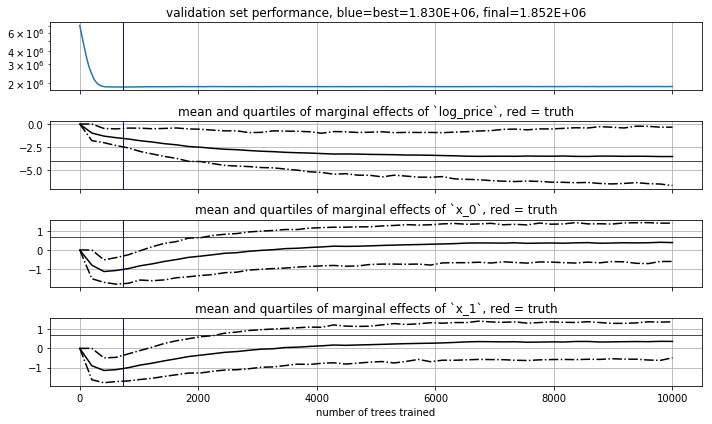

In [57]:
wrapped_gbm2 = model_wrapper.ModelWrapper(npiv_true_stage1_linear_stage2.stage2_model)
plot_performance_and_implied_margin_effects_vs_iteration(wrapped_gbm2, df_test, num_grid_pts=50)

In [ ]:
assert False

# II. try quantiles

In [4]:
# initialize a nonparametric IV model that estimates quantiles in the first stage and uses a linear
#  specification in the second stage
npiv_estimate_stage1_linear_stage2 = NonparametricIV(df=df_train,
                                                     exog_x_cols=ivsim.exog_x_cols, 
                                                     instrument_cols = ['instrument'],
                                                     endog_x_col=ivsim.endog_x_col,
                                                     y_col=ivsim.y_col,
                                                     id_col='id')

In [6]:
# train the stage1 models for the model that requires training
npiv_estimate_stage1_linear_stage2.train_stage1()

alpha=0.05
Training until validation scores don't improve for 100 rounds.
[100]	train's quantile: 0.0240815	val's quantile: 0.0272374
[200]	train's quantile: 0.0161708	val's quantile: 0.0185011
[300]	train's quantile: 0.0141699	val's quantile: 0.0164361
[400]	train's quantile: 0.0134475	val's quantile: 0.0157579
[500]	train's quantile: 0.0131027	val's quantile: 0.0154873

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:112: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[600]	train's quantile: 0.0129485	val's quantile: 0.0153742
[700]	train's quantile: 0.0128417	val's quantile: 0.0153255
[800]	train's quantile: 0.0127583	val's quantile: 0.0152745
[900]	train's quantile: 0.0126965	val's quantile: 0.0152377
[1000]	train's quantile: 0.0126505	val's quantile: 0.0152289
Did not meet early stopping. Best iteration is:
[999]	train's quantile: 0.0126498	val's quantile: 0.0152305
alpha=0.15000000000000002
Training until validation scores don't improve for 100 rounds.
[100]	train's quantile: 0.0476907	val's quantile: 0.0523872
[200]	train's quantile: 0.0380489	val's quantile: 0.0413941
[300]	train's quantile: 0.0367315	val's quantile: 0.0402406
[400]	train's quantile: 0.0362791	val's quantile: 0.0400083
[500]	train's quantile: 0.0360028	val's quantile: 0.0397913
[600]	train's quantile: 0.0358341	val's quantile: 0.0397258
[700]	train's quantile: 0.0357192	val's quantile: 0.039673
[800]	train's quantile: 0.0356327	val's quantile: 0.0396294
[900]	train's quantile

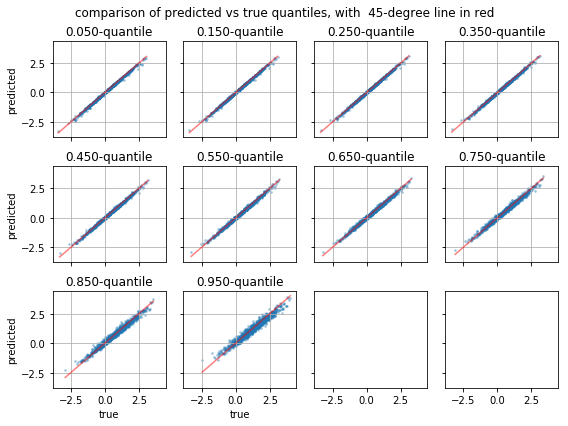

In [7]:
# compare the predicted vs true quantiles
qtl_comp_df = pd.concat([
                            npiv_estimate_stage1_linear_stage2.predict_stage1(df_test, prefix='predicted_qtl'),
                            npiv_true_stage1_linear_stage2.predict_stage1(df_test, prefix='true_qtl')
                        ], axis=1)
# plot
plot_df = qtl_comp_df.sample(1000)
alphas = npiv_estimate_stage1_linear_stage2.stage1_params.keys()
ncols=4
nrows = int(np.ceil(len(alphas)/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 2*nrows), 
                         sharex=True, sharey=True)
for i,alpha in enumerate(alphas):
    ax = axes[i//ncols][i%ncols]
    true_col = 'true_qtl_{:.3f}'.format(alpha)
    pred_col = 'predicted_qtl_{:.3f}'.format(alpha)
    tmp_df = plot_df[[true_col, pred_col]].rename(columns={true_col:'true', pred_col:'predicted'})
    tmp_df.plot(x='true', y = 'predicted', ax=ax, kind='scatter',
                 alpha=.3, s=3, title="{:.3f}-quantile".format(alpha), grid=True)
    # also plot the 45-degree line
    min45, max45 = tmp_df['true'].min(), tmp_df['true'].max()
    ax.plot([min45, max45], [min45, max45], color='red', alpha=.5)
plt.suptitle("comparison of predicted vs true quantiles, with  45-degree line in red")
plt.tight_layout()
plt.subplots_adjust(top=0.9)

In [8]:
# ok, quantiles look fine.

### 2. stage2 : nonparametric IV

In [10]:
# and also for when we predict quantiles
npiv_estimate_stage1_linear_stage2.train_stage2()

# print some marginal effects
wrapped_gbm2 = model_wrapper.ModelWrapper(npiv_estimate_stage1_linear_stage2.stage2_model)
marginal_fx = wrapped_gbm2.marginal_effect_plots(df_test, plot=False)
display(marginal_fx.groupby('feature name').describe().transpose())

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:107: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	train's grouped sse: 1.72561e+06	val's grouped sse: 1.99444e+06
[2000]	train's grouped sse: 1.66909e+06	val's grouped sse: 2.06203e+06
[3000]	train's grouped sse: 1.64732e+06	val's grouped sse: 2.11136e+06
[4000]	train's grouped sse: 1.63841e+06	val's grouped sse: 2.1371e+06
[5000]	train's grouped sse: 1.63391e+06	val's grouped sse: 2.15377e+06
[6000]	train's grouped sse: 1.63075e+06	val's grouped sse: 2.15986e+06
[7000]	train's grouped sse: 1.62829e+06	val's grouped sse: 2.16285e+06
[8000]	train's grouped sse: 1.62705e+06	val's grouped sse: 2.16809e+06
[9000]	train's grouped sse: 1.62558e+06	val's grouped sse: 2.17235e+06
[10000]	train's grouped sse: 1.62453e+06	val's grouped sse: 2.17859e+06


feature name              log_price           x_0           x_1
marginal effect count  10000.000000  10000.000000  10000.000000
                mean      -2.157670     -0.604114     -0.548336
                std        8.142092      3.329766      3.418791
                min      -48.592676    -11.132499    -14.293015
                25%       -6.284028     -2.636495     -2.780144
                50%       -2.310696     -0.353017     -0.552992
                75%        1.645515      1.498539      1.645263
                max       37.233190     11.861634     10.909346

In [11]:
ivsim.log_sales_coefs

x_0          0.707107
x_1          0.707107
log_price   -4.000000
dtype: float64

In [12]:
assert False

AssertionError: 

In [ ]:
assert False

In [ ]:
npiv_estimate_stage1_linear_stage2.stage2_data['_qtl_'].describe()

In [ ]:
npiv_estimate_stage1_linear_stage2.stage2_data['_qtl_'].shape

In [ ]:
npiv_estimate_stage1_linear_stage2.stage2_data.head()

In [ ]:
npiv_estimate_stage1_linear_stage2.stage1_qtls

In [ ]:
assert False

In [ ]:
df.head()

In [ ]:
df['log_price'].iloc[:10]

In [ ]:
np.repeat('jacob', 3)

In [ ]:
np.concatenate([np.repeat('jacob', 3), np.repeat('haitao', 4)])

In [ ]:
gbm = npiv_model.stage1_models[.05]

In [ ]:
npiv_model.stage1_params

In [ ]:
npiv_model.stage1_models[.05].eval_results['val']['quantile']

In [ ]:
df.columns